<a href="https://colab.research.google.com/github/AtlastDeepLearning/Intestinal-Parasite-Classification-LW-CNN/blob/main/efficientNet_B0_LW_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

# Grayscaled Feature Extraction in Efficientnet

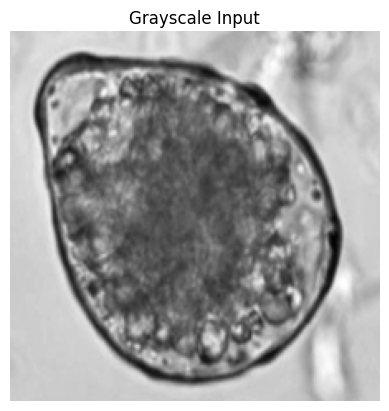

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size=(224, 224)):
    # Read image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Error: Could not load image from {img_path}")

    # Resize to model input size
    img = cv2.resize(img, target_size)

    # Expand to 3 channels for pretrained CNNs
    img = np.stack([img] * 3, axis=-1)

    # Normalize
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Example usage
img_path = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train/ascaris_lumbricoides/(1) 21090.png"  # 👈 Make sure this file exists
gray_img = preprocess_image(img_path)

plt.imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap="gray")
plt.title("Grayscale Input")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


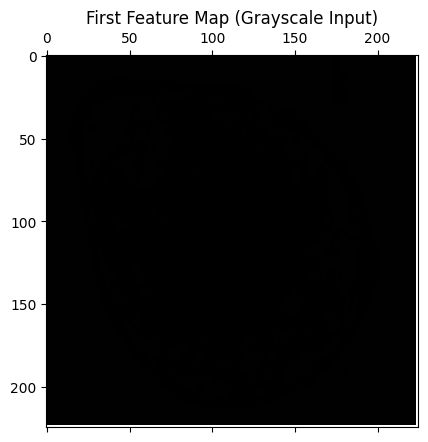

In [ ]:
# Extract activations from grayscale image
activations = activation_model.predict(gray_img)

# Visualize the first feature map from the first layer
plt.matshow(activations[0][0, :, :, 0], cmap='gray')
plt.title("First Feature Map (Grayscale Input)")
plt.show()

# Modified Grayscaled Feature Extraction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


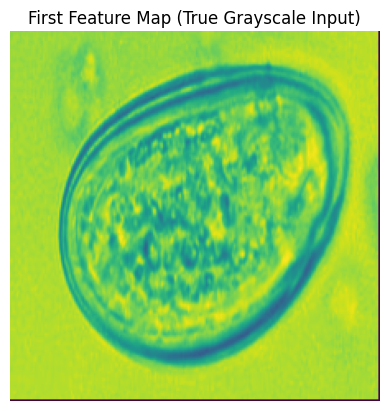

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Input
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 🔹 Load EfficientNetB0 but exclude top
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224,224,1))

# Example: Load and preprocess grayscale image
def preprocess_gray(img_path, target_size=(224,224)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or path incorrect")
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # add channel dim
    img = np.expand_dims(img, axis=0)   # batch dim
    return img

# Get activations from first few conv layers
layer_names = [layer.name for layer in base_model.layers if "conv" in layer.name][:5]
activation_model = Model(inputs=base_model.input,
                         outputs=[base_model.get_layer(name).output for name in layer_names])

# Test with sample image
img_path = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train/enterobius_vermicularis/(1).png"
gray_img = preprocess_gray(img_path)

activations = activation_model.predict(gray_img)

# Visualize the first feature map
first_activation = activations[0][0, :, :, 0]  # first conv, first channel
plt.imshow(first_activation, cmap="viridis")
plt.title("First Feature Map (True Grayscale Input)")
plt.axis("off")
plt.show()

# Training Code for Efficientnet b0

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = (224, 224)  # EfficientNetB0 default
BATCH_SIZE = 16
EPOCHS = 30
DATASET_DIR_TRAIN = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train"
DATASET_DIR_VAL = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/validate"

In [ ]:
def grayscale_to_rgb(img):
    # img is (H, W, 1), expand to (H, W, 3)
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    # Ensure values in [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Expand grayscale to 3-channel
    img = grayscale_to_rgb(img)
    return img

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator() # No augmentation for validation

train_gen = train_datagen.flow_from_directory(
    f"{DATASET_DIR_TRAIN}",
    target_size=IMG_SIZE,
    color_mode="grayscale",   # load as grayscale first
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    f"{DATASET_DIR_VAL}",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Apply custom preprocessing to convert grayscale to RGB
def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

train_gen_processed = preprocess_generator(train_gen)
val_gen_processed = preprocess_generator(val_gen)

Found 400 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))  # force RGB input
)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Freeze base for transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
checkpoint = ModelCheckpoint("efficientnet_parasite.h5", save_best_only=True, monitor="val_accuracy", mode="max")
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop],
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3490 - loss: 1.3634

25/25 ━━━━━━━━━━━━━━━━━━━━ 282s 11s/step - accuracy: 0.3531 - loss: 1.3575 - val_accuracy: 0.5938 - val_loss: 1.0752
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7540 - loss: 0.7545

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.7551 - loss: 0.7524 - val_accuracy: 0.6250 - val_loss: 0.9705
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8294 - loss: 0.5879 - val_accuracy: 0.5938 - val_loss: 0.9123
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.8455 - loss: 0.4612 - val_accuracy: 0.5938 - val_loss: 0.8728
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.8718 - loss: 0.4200 - val_accuracy: 0.5938 - val_loss: 0.8890
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.9139 - loss: 0.3317 - val_accuracy: 0.5625 - val_loss: 0.8822
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8835 - loss: 0.3414 - val_accuracy: 0.5312 - val_loss: 0.9160
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9220 - loss: 0.2775 - val_accuracy: 0.5312 - val_loss: 0.8905
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9564 - loss: 0.2325 - val_accuracy: 0.5312 - val_l

In [ ]:
for layer in base_model.layers[-30:]:  # unfreeze last 30 layers
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=10,
    callbacks=[checkpoint, earlystop],
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8088 - loss: 0.6371

25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 964ms/step - accuracy: 0.8083 - loss: 0.6375 - val_accuracy: 0.8750 - val_loss: 0.5397
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8405 - loss: 0.6105

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.8399 - loss: 0.6109 - val_accuracy: 0.9167 - val_loss: 0.5339
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.8569 - loss: 0.5325 - val_accuracy: 0.9167 - val_loss: 0.5341
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.8868 - loss: 0.5029 - val_accuracy: 0.9167 - val_loss: 0.5352
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8516 - loss: 0.5248 - val_accuracy: 0.8750 - val_loss: 0.5385
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8911 - loss: 0.4693 - val_accuracy: 0.9167 - val_loss: 0.5402
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8547 - loss: 0.4645 - val_accuracy: 0.8333 - val_loss: 0.5426


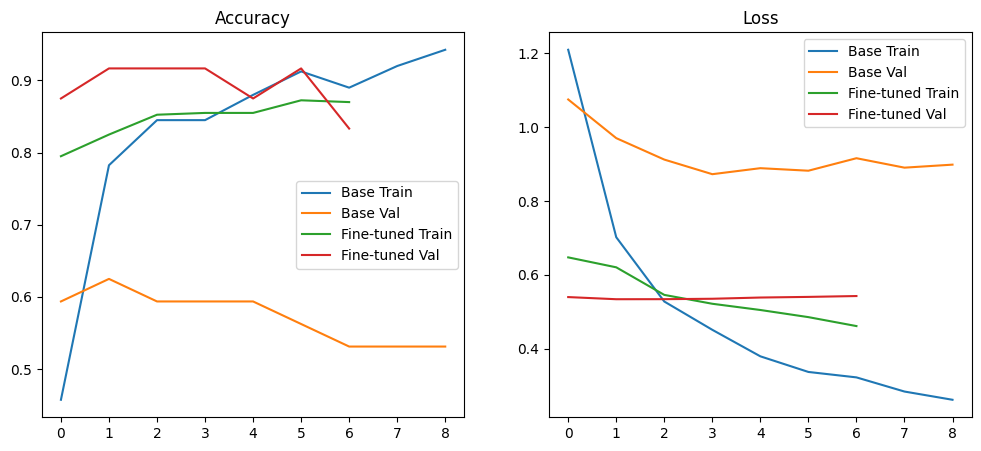

In [ ]:
def plot_history(histories, title="Training History"):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    for name, history in histories:
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    for name, history in histories:
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history([("Base", history), ("Fine-tuned", history_fine)])

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
val_gen.reset()
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))


Classification Report:
                         precision    recall  f1-score   support

   ascaris_lumbricoides     0.8333    1.0000    0.9091        10
enterobius_vermicularis     0.6250    1.0000    0.7692        10
              hookworms     1.0000    0.3000    0.4615        10
    trichuris_trichiura     0.7778    0.7000    0.7368        10

               accuracy                         0.7500        40
              macro avg     0.8090    0.7500    0.7192        40
           weighted avg     0.8090    0.7500    0.7192        40



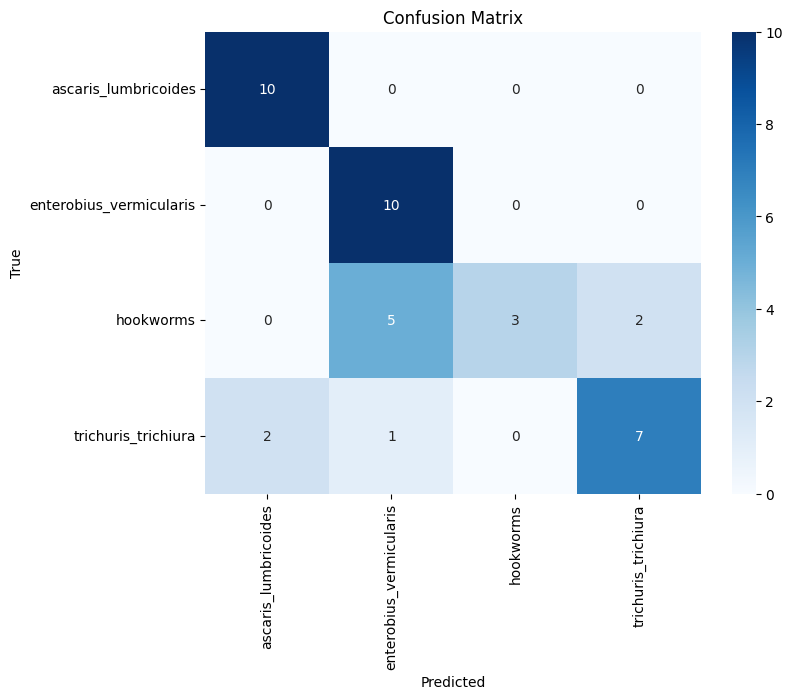

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Macro (treats all classes equally)
f1_macro = f1_score(y_true, y_pred, average="macro")
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")

# Weighted (accounts for imbalance)
f1_weighted = f1_score(y_true, y_pred, average="weighted")
precision_weighted = precision_score(y_true, y_pred, average="weighted")
recall_weighted = recall_score(y_true, y_pred, average="weighted")

print("Macro Precision: {:.4f}, Macro Recall: {:.4f}, Macro F1: {:.4f}".format(
    precision_macro, recall_macro, f1_macro))
print("Weighted Precision: {:.4f}, Weighted Recall: {:.4f}, Weighted F1: {:.4f}".format(
    precision_weighted, recall_weighted, f1_weighted))

Macro Precision: 0.8090, Macro Recall: 0.7500, Macro F1: 0.7192
Weighted Precision: 0.8090, Weighted Recall: 0.7500, Weighted F1: 0.7192


In [ ]:
model.save("efficientnet_parasite_final.keras")

# Save in TensorFlow SavedModel format
model.export("efficientnet_parasite_final")

Saved artifact at 'efficientnet_parasite_final'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')]
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135419313465168: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135419313470928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135419380005392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135419380006160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135419374568656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135419380004432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135419380005968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135419374569040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135419374570768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135419374570960: TensorSpec(shape=(), dtype=tf.re

In [ ]:
import tensorflow as tf
import numpy as np

IMG_SIZE = (224, 224)

def preprocess_image_inference(image_path):
    # Load grayscale first
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE, color_mode="grayscale")
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # (H,W,1)

    # Match training preprocessing
    img_array = tf.image.convert_image_dtype(img_array, tf.float32)  # [0,1]
    img_array = tf.image.grayscale_to_rgb(img_array)                 # (H,W,3)

    # Add batch dimension
    img_array = np.expand_dims(img_array.numpy(), axis=0)
    return img_array

In [ ]:
img_batch = preprocess_image_inference("/content/drive/MyDrive/Thesis/dataset/train/enterobius_vermicularis/Enterobius vermicularis_0010.jpg")
pred = model.predict(img_batch)
predicted_class = np.argmax(pred, axis=1)[0]

print("Predicted:", list(train_gen.class_indices.keys())[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted: enterobius_vermicularis


Found 40 images belonging to 4 classes.


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step

Classification Report:

                         precision    recall  f1-score   support

   ascaris_lumbricoides       0.83      1.00      0.91        10
enterobius_vermicularis       0.62      1.00      0.77        10
              hookworms       1.00      0.30      0.46        10
    trichuris_trichiura       0.78      0.70      0.74        10

               accuracy                           0.75        40
              macro avg       0.81      0.75      0.72        40
           weighted avg       0.81      0.75      0.72        40



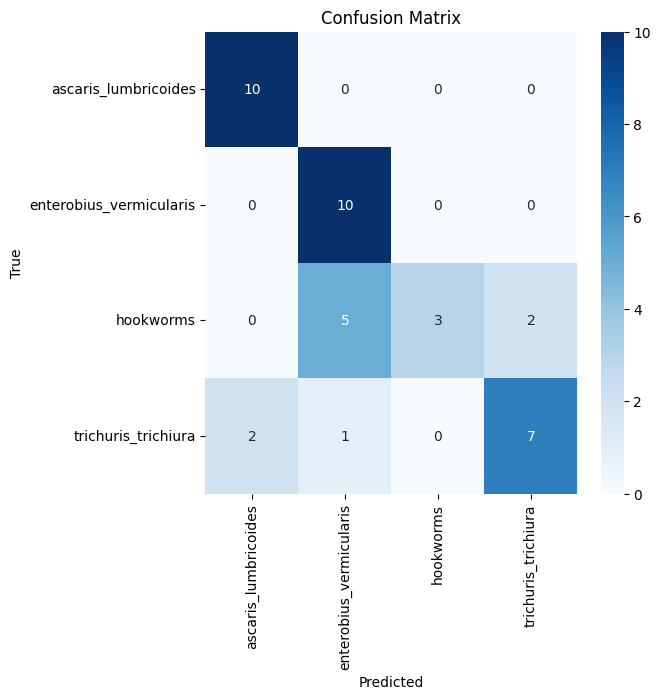

In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Config
# ======================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
TEST_DIR = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/validate"
MODEL_PATH = "/content/efficientnet_parasite_final.h5"

# ======================
# Preprocessing (SAME as training)
# ======================
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale [0,1]
    img = grayscale_to_rgb(img)                         # expand to RGB
    return img

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

# ======================
# Load Data
# ======================
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen_processed = preprocess_generator(test_gen)

# ======================
# Load Model
# ======================
model = tf.keras.models.load_model(MODEL_PATH)

# ======================
# Predictions
# ======================
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen_processed, steps=test_gen.samples // BATCH_SIZE + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

# ======================
# Evaluation
# ======================
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Test Training

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 60
DATASET_DIR_TRAIN = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train"
DATASET_DIR_VAL = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/validate"

In [2]:
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = grayscale_to_rgb(img)
    return img

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
    vertical_flip=True,
    fill_mode="nearest"
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR_TRAIN,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR_VAL,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

train_gen_processed = preprocess_generator(train_gen)
val_gen_processed = preprocess_generator(val_gen)

Found 400 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [10]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)  # increase dropout for better generalization

outputs = Dense(
    train_gen.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4)
)(x)

model = Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)
]

steps_per_epoch = len(train_gen)
val_steps = len(val_gen)

history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks
)

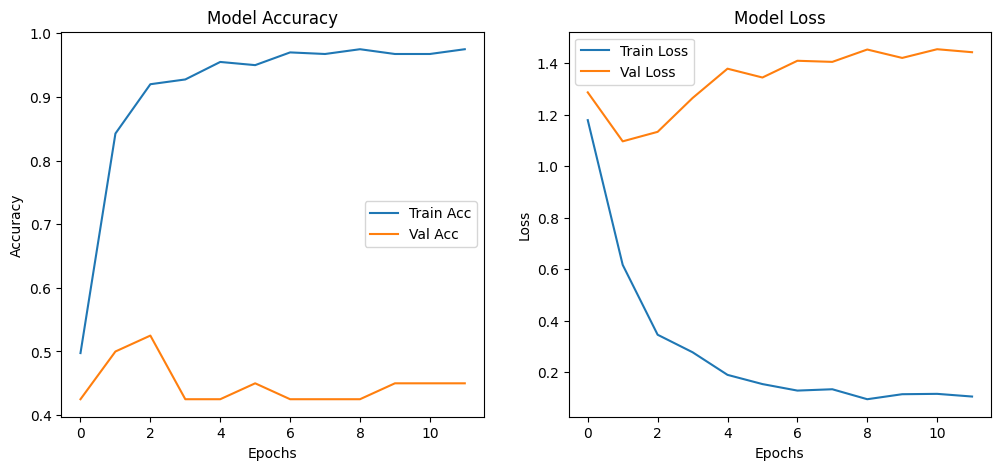

In [8]:
import matplotlib.pyplot as plt

# --- Plot accuracy and loss ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step

Classification Report:

                         precision    recall  f1-score   support

   ascaris_lumbricoides       1.00      0.40      0.57        10
enterobius_vermicularis       0.36      0.90      0.51        10
              hookworms       0.60      0.60      0.60        10
    trichuris_trichiura       1.00      0.10      0.18        10

               accuracy                           0.50        40
              macro avg       0.74      0.50      0.47        40
           weighted avg       0.74      0.50      0.47        40

Confusion Matrix:
 [[4 3 3 0]
 [0 9 1 0]
 [0 4 6 0]
 [0 9 0 1]]


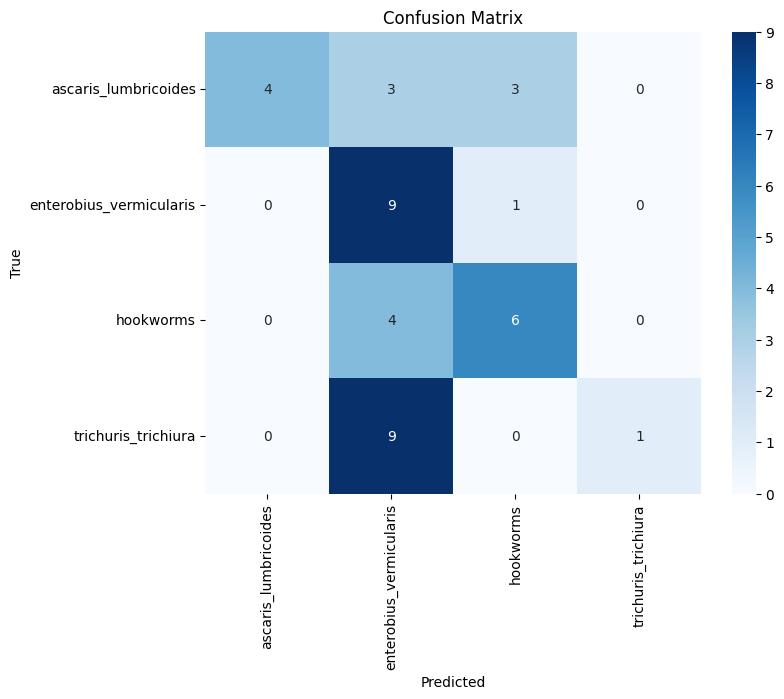

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Reload best model
best_model = tf.keras.models.load_model("best_model.keras")

# Evaluate on validation set
val_gen.reset()  # reset before predicting
pred_probs = best_model.predict(val_gen, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# --- Classification report ---
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# --- Confusion matrix ---
cm = confusion_matrix(true_classes, pred_classes)
print("Confusion Matrix:\n", cm)

# --- Plot Confusion Matrix ---
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()